<a href="https://colab.research.google.com/github/philarnold4242/test_Python/blob/master/Bayesian_DL_ConvNet_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4 - Convolutional Neural Nets<br>
https://www.tensorflow.org/tutorials/deep_cnn

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Uncertainties<br>
Helper functions

In [0]:
# Pseudocount - needs thinking.
pc = 1e-10

def softmax(x):
    """ Multinomial logisitc fuction. """
    mmax = np.amax(x, axis=1).reshape(x.shape[0], 1)
    ex = np.exp(x - mmax)
    ex_sum = ex.sum(axis=1).reshape(ex.shape[0],1)
    return ex / ex_sum
    

def var_ratio(x):
    """ How spread is the distribution around the mode?""" 
    ratios = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(x.shape[1]):
        
        # Get predicted class
        samples_n = np.argmax(x[:, n], axis=1)
        
        # Get most abundant class
        count = np.argmax(np.bincount(samples_n))
        
        # Return frequency of class
        ratios[n] = np.sum(samples_n==count) / x.shape[0]

    return ratios


def pred_ent(x):
    """ Average amount of information contained in posterior predictive distribution. """
    
    N = x.shape[1] # Number of test cases
    T = x.shape[0] # Number of samples per test case
    C = 10 # number of classes
    
    entropies = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(N):
        
        # Approx posterior predictive distribution
        ppd = np.mean(x[:,n,:] + pc, axis=0)
        
        # Calculate predictive entropy
        entropies[n] = - np.sum(np.multiply(ppd, np.log(ppd)))
    
    return entropies


def mut_inf(x):
    """ MI between prediction y_pred and posterior distribution for the model parameters. """
    
    N = x.shape[1] # Number of test cases
    T = x.shape[0] # Number of samples per test case
    C = 10 # number of classes
        
    mis = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(N):
        
        # Approx posterior predictive distribution
        ppd = np.mean(x[:,n,:] + pc, axis=0)
        
        # Calculate predictive entropy
        pe = - np.sum(np.multiply(ppd, np.log(ppd)))
        
        # Calculate conditional entropy        
        p = x[:,n,:] + pc
        logp = np.log(p)
        ce = np.sum(np.multiply(p,logp))
        
        mis[n] = 1/T * pe + ce
    
    return mis

## **Let's get started**

### Set up modules

In [0]:
import os
import sys

import numpy as np
np.set_printoptions(precision=5)

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import urllib
import tarfile

!pip install git+git://github.com/rasbt/mlxtend.git
from mlxtend.data import loadlocal_mnist

import tensorflow as tf
print(tf.__version__)

  Cloning git://github.com/rasbt/mlxtend.git to /tmp/pip-req-build-s3i5bhmk
  Running setup.py bdist_wheel for mlxtend ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-rtn9xxr0/wheels/85/e4/4c/ee71547ac9ea223b07fe8f55b0e5f71536a6a34ae3480205f3
Successfully built mlxtend
1.12.0


In [0]:
## Check GPU
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


### ConvNet - The hard way

In [0]:
## Load MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
## Helper functions
def weight_variable(shape):
    """ Specifies the weight for either fully-connected or conv layers."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """ Bias elements. """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    """ This specifies a full convolution with an output the same size
        as the input x. 
        [batch, height, width, channels] """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """ ksize: A 1-D int Tensor of 4 elements. The size of the window for each 
               dimension of the input tensor.
        strides: A 1-D int Tensor of 4 elements. The stride of the sliding window for 
                 each dimension of the input tensor. """
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [0]:
## Architecture parameters
pic_res = 28
n_channel = 1

# Placeholders to feed stuff to network
x = tf.placeholder(tf.float32, shape=[None, pic_res*pic_res])
y_true = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)


N = 200 # Number of samples for forward pass
Ntrain_steps = 20000
bayesian_keep_prob = 0.8

In [0]:
def create_convnet(do_bayes = False):
  ## The net
  # Remember, the input image is a 1D tensor of length 784.
  mnist.train.images[1].shape

  # To apply the layer, we first reshape x to a 4d tensor, with the second and 
  # third dimensions corresponding to image width and height, and the final dimension 
  # corresponding to the number of color channels.
  x_image = tf.reshape(x, [-1, pic_res, pic_res, n_channel])

  # First conv layer
  # The convolution will compute 32 features for each 3x3 patch. Its weight tensor will have a 
  # shape of [3, 3, 1, 32]. The first two dimensions are the patch size, the next is the number 
  # of input channels, and the last is the number of output channels. 
  W_conv1 = weight_variable([3, 3, n_channel, 32])
  b_conv1 = bias_variable([32])
  conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  if do_bayes:
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)
  h_pool1 = max_pool_2x2(conv1)

  # Second conv layer
  W_conv2 = weight_variable([3, 3, 32, 64])
  b_conv2 = bias_variable([64])
  conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  if do_bayes:
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
  h_pool2 = max_pool_2x2(conv2)

  # Dense layer 
  pic_res4_sq = int(pic_res/4)*int(pic_res/4)
  W_fc1 = weight_variable([pic_res4_sq * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, pic_res4_sq*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
  # Dropout
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=keep_prob)

  # Output
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob=keep_prob)
  y_conv = h_fc2_drop
  
  return(y_conv)

## Tranditional ConvNet

In [0]:
# Objective function
y_conv = create_convnet(do_bayes = False)
y_pred = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_conv)
cross_entropy = tf.reduce_mean(y_pred)

# Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluation
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
## Train - MNIST
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(int(Ntrain_steps)+1):
    batch = mnist.train.next_batch(64)

    # Training
    _, loss = sess.run([train_step, cross_entropy], 
                       feed_dict={x: batch[0], y_true: batch[1], 
                                  keep_prob: float(bayesian_keep_prob)})
    
    # Status report
    if i % 1000 == 0:
        train_acc = sess.run(accuracy, feed_dict={x: batch[0], 
                                                  y_true: batch[1], 
                                                  keep_prob: float(1.0)})
        
        test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,
                                                  y_true: mnist.test.labels, 
                                                  keep_prob: 1.0})
        info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
        print('\t'.join(info))

0	4.7984467	0.109375	0.1128
1000	0.3629266	1.0	0.9586
2000	0.27385744	0.96875	0.9723
3000	0.28072077	1.0	0.9817
4000	0.26521128	0.984375	0.9822
5000	0.21265593	0.984375	0.9869
6000	0.3065703	0.984375	0.9887
7000	0.17142633	1.0	0.9876
8000	0.23067905	1.0	0.9891
9000	0.15771323	1.0	0.99
10000	0.2611502	1.0	0.9905
11000	0.19413567	1.0	0.9893
12000	0.11987758	1.0	0.9908
13000	0.27303657	1.0	0.9914
14000	0.24158649	1.0	0.9901
15000	0.14956823	1.0	0.9904
16000	0.22842099	0.984375	0.9911
17000	0.20375058	1.0	0.9912
18000	0.14236963	1.0	0.9911
19000	0.19692509	1.0	0.9914
20000	0.13233367	1.0	0.992


In [0]:
# Get predictions
y_prob = tf.nn.softmax(y_conv)
pred_trad = sess.run(y_prob, feed_dict={x: mnist.test.images,
                                          y_true: mnist.test.labels, 
                                          keep_prob: 1.0})


labels_trad = np.argmax(pred_trad, axis=1)
probs_trad = np.max(pred_trad, axis=1)

## Bayesian ConvNet

In [0]:
# Objective function
By_conv = create_convnet(do_bayes = True)
By_pred = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=By_conv)
Bcross_entropy = tf.reduce_mean(By_pred)

# Optimizer
Btrain_step = tf.train.AdamOptimizer(1e-4).minimize(Bcross_entropy)

# Evaluation
Bcorrect_prediction = tf.equal(tf.argmax(By_conv, 1), tf.argmax(y_true, 1))
Baccuracy = tf.reduce_mean(tf.cast(Bcorrect_prediction, tf.float32))

In [0]:
## Train - MNIST
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(int(Ntrain_steps)+1):
    batch = mnist.train.next_batch(64)

    # Training
    _, loss = sess.run([Btrain_step, Bcross_entropy], 
                       feed_dict={x: batch[0], y_true: batch[1], 
                                  keep_prob: float(bayesian_keep_prob)})
    
    # Status report
    if i % 1000 == 0:
        train_acc = sess.run(Baccuracy, feed_dict={x: batch[0], 
                                                  y_true: batch[1], 
                                                  keep_prob: float(1.0)})
        
        test_acc = sess.run(Baccuracy, feed_dict={x: mnist.test.images,
                                                  y_true: mnist.test.labels, 
                                                  keep_prob: 1.0})
        info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
        print('\t'.join(info))

0	6.106655	0.125	0.1657
1000	0.2945533	0.953125	0.958
2000	0.278653	1.0	0.9735
3000	0.3566081	1.0	0.9804
4000	0.29591033	1.0	0.9835
5000	0.25739187	0.984375	0.9854
6000	0.2624533	1.0	0.9883
7000	0.3505632	1.0	0.9882
8000	0.2769012	0.984375	0.9902
9000	0.120537475	1.0	0.991
10000	0.17430952	1.0	0.9913
11000	0.18917799	1.0	0.9912
12000	0.24237102	1.0	0.9911
13000	0.2735782	1.0	0.9927
14000	0.20978107	1.0	0.9925
15000	0.20811015	1.0	0.9926
16000	0.26158676	1.0	0.9914
17000	0.25177842	1.0	0.9932
18000	0.13369304	1.0	0.9916
19000	0.16718253	1.0	0.9917
20000	0.13704832	1.0	0.9921


**Uncertainties from stochastic forward passes**

In [0]:
## Stochastic forward passes
samples = np.zeros( shape=(N, mnist.test.images.shape[0], 10))

for n in range(N):
    logits = sess.run(By_conv, feed_dict={x: mnist.test.images, 
                                          y_true: mnist.test.labels,
                                         keep_prob: bayesian_keep_prob})
    samples[n] = softmax(logits)

In [0]:
# Variation ratio
vr = var_ratio(samples)

# Predictive entropy
pe = pred_ent(samples)

# Mutual information
mi = mut_inf(samples)

mi

array([-41.50894, -37.85634, -41.85383, ..., -29.22932, -38.40325,
       -30.23868])

In [0]:
# Bayesian predictions
samples_avg = np.sum(samples, axis=0) / N
labels_bayes = np.argmax(samples_avg, axis=1)
probs_bayes = np.max(samples_avg, axis=1)

## Comparison: Bayes vs Trad

In [0]:
ref = np.argmax(mnist.test.labels, axis=1)
data = { 'true': ref.tolist(),
         'labels_trad': labels_trad.tolist(),
         'probs_trad': probs_trad.tolist(),
         'labels_bayes': labels_bayes.tolist(),
         'probs_bayes': probs_bayes.tolist(),
         'vr': vr.tolist(),
         'pe': pe.tolist(),
         'mi': mi.tolist()}

df = pd.DataFrame(data)

df = df.assign(correct_trad = df.true == df.labels_trad)
df = df.assign(correct_bayes = df.true == df.labels_bayes)

df_both_wrong = df[(df.correct_trad == False) & (df.correct_bayes == False)]
df_both_right = df[(df.correct_trad == True) & (df.correct_bayes == True)]


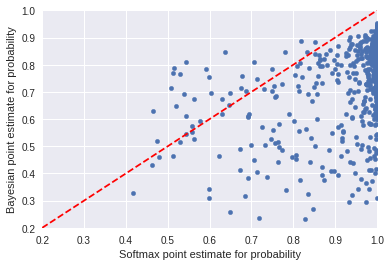

In [0]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = "red")

# Best guess
# Traditional approach is much more confidennt than Bayesian approach
ax = df.plot.scatter(x = 'probs_trad', y = 'probs_bayes')
ax.set_xlim(0.2, 1)
ax.set_ylim(0.2, 1)
ax.set_xlabel("Softmax point estimate for probability")
ax.set_ylabel("Bayesian point estimate for probability")
abline(1, 0)

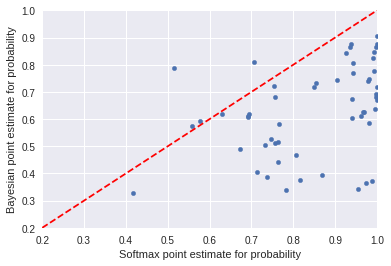

In [0]:
# Things both got wrong
ax = df_both_wrong.plot.scatter(x = 'probs_trad', y = 'probs_bayes')
ax.set_xlim(0.2, 1)
ax.set_ylim(0.2, 1)
ax.set_xlabel("Softmax point estimate for probability")
ax.set_ylabel("Bayesian point estimate for probability")
abline(1, 0)

In [0]:
# Uncertainty measure for correct / incorrectly predicted digits
df_bayes_correct = df[df.correct_bayes == True]
df_bayes_wrong = df[df.correct_bayes == False]

cum_c = np.cumsum(df_bayes_correct.pe)
cum_w = np.cumsum(df_bayes_wrong.pe)


print(sum(df_bayes_correct.pe) / len(df_bayes_correct))
print(sum(df_bayes_wrong.pe) / len(df_bayes_wrong))

df.to_csv('/content/drive/My Drive/Colab Notebooks/out.csv')



# awk -F, '{ if($11=="True") {print $5}}' out.csv  | sort -k1,1gr > pe.true
# awk -F, '{ if($11=="False") {print $5}}' out.csv  | sort -k1,1gr > pe.false
# plot 'pe.true' u 1:($0/9871) title "Correct", 'pe.false' u 1:($0/129) title "Incorrect"

0.6090864855167594
1.2950307956162894


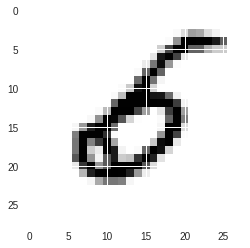

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


,labels_bayes,labels_trad,mi,pe,probs_bayes,probs_trad,true,vr,correct_trad,correct_bayes
259,0,0,-167.394347,1.515802,0.515170,0.764494,6,0.655,False,False
445,0,0,-123.320945,1.173245,0.693784,0.996533,6,0.860,False,False
582,2,2,-58.441600,0.665186,0.863769,0.936639,8,0.915,False,False
583,7,7,-98.772690,0.976967,0.592227,0.577771,2,0.640,False,False
659,7,1,-203.434999,1.553480,0.467368,0.806227,2,0.595,False,False
947,9,9,-96.769333,0.915554,0.805700,0.943317,8,0.830,False,False
1014,5,5,-114.718100,1.067069,0.740422,0.978160,6,0.785,False,False
1226,2,2,-45.967080,0.647635,0.874662,0.937546,7,0.950,False,False
1232,4,4,-142.337072,1.184733,0.719963,0.752795,9,0.845,False,False
1247,5,5,-215.882795,1.971716,0.395604,0.869668,9,0.495,False,False


In [0]:
k = 9729
# 9729	6	6	-36.121928	0.768686	0.829598	0.995529	5	0.82	False	False
plt.imshow(mnist.test.images[k].reshape(28,28))
plt.show()
print(mnist.test.labels[k])
df_both_wrong

## EMnist
We know that in this case, the data set is out of distribution. Usually, we don't have this information.

In [0]:
# Download data set from here: https://www.nist.gov/itl/iad/image-group/emnist-dataset
# Upload to gDrive
# Copy from gDrive
!cp '/content/drive/My Drive/Colab Notebooks/emnist.zip' .

!rm -fr gzip

# Unzip
!unzip emnist.zip

In [0]:
import gzip

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def extract_images(filename):
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError(
                'Invalid magic number %d in MNIST image file: %s' %
                (magic, filename))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data


def extract_labels(filename):
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
              'Invalid magic number %d in MNIST label file: %s' %
              (magic, filename))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        return labels


def read_emnist(emnist_dir):

    TRAIN_IMAGES = emnist_dir+'/emnist-balanced-train-images-idx3-ubyte.gz'
    TRAIN_LABELS = emnist_dir+'/emnist-balanced-train-labels-idx1-ubyte.gz'
    TEST_IMAGES = emnist_dir+'/emnist-balanced-test-images-idx3-ubyte.gz'
    TEST_LABELS = emnist_dir+'/emnist-balanced-test-labels-idx1-ubyte.gz'
    MAPPING = emnist_dir+'/emnist-balanced-mapping.txt'

    train_images = extract_images(TRAIN_IMAGES)
    train_labels = extract_labels(TRAIN_LABELS)
    test_images = extract_images(TEST_IMAGES)
    test_labels = extract_labels(TEST_LABELS)

    with open(MAPPING, "r") as f:
        mapping = f.readlines()
        mapping = {str(x.split()[0]): str(x.split()[1]) for x in mapping}

    # Convert to float32
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # Normalize
    train_images /= 255
    test_images /= 255

    # Output format: (28, 28, 1)
    return ((train_images, train_labels), (test_images, test_labels), mapping)

In [0]:
emnist = read_emnist('gzip')

X = np.float32(emnist[1][0].reshape(18800, 784))
y = np.float32(emnist[1][1])
X.shape

In [0]:
# Predict digits
eN = 18800

y_prob = tf.nn.softmax(y_conv)
pred_trad = sess.run(y_prob, feed_dict={x: X,
                                          y_true: mnist.test.labels, 
                                          keep_prob: float(1.0)})


labels_trad = np.argmax(pred_trad, axis=1)
probs_trad = np.max(pred_trad, axis=1)

Eprobs_trad = probs_trad

In [0]:
## Stochastic forward passes
Esamples = np.zeros( shape=(N, X.shape[0], 10))

for n in range(N):
    logits = sess.run(By_conv, feed_dict={x: X, 
                                          y_true: mnist.test.labels[0:eN],
                                          keep_prob: 0.9})
    Esamples[n] = softmax(logits)

Esamples_avg = np.sum(Esamples, axis=0) / N
Elabels_bayes = np.argmax(Esamples_avg, axis=1)
Eprobs_bayes = np.max(Esamples_avg, axis=1)

In [0]:
print(Eprobs_trad.shape)
print(Eprobs_bayes.shape)
ax = plt.scatter(Eprobs_trad, Eprobs_bayes)
plt.xlim(0.2, 1)
plt.ylim(0.2, 1)
plt.xlabel("Softmax point estimate for probability")
plt.ylabel("Bayesian point estimate for probability")
abline(1, 0)

In [0]:
# Pick some examples
As = np.argwhere(y==15)

i = 11215

print(y[i])
print(Eprobs_trad[i], "; ")
print(Eprobs_bayes[i], "; ", Elabels_bayes[i])

plt.imshow(X[i].reshape((28,28)))

In [0]:
As